# Code to explore the embedding space 
Author: Weiyu Zhang

Description: This code implements UMAP dimensionality reduction of embeddings and visualizes the UMAP projected embedding space.

# Import dependencies

In [ ]:
# Standard library imports
import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings

# Data manipulation and scientific computing
import numpy as np
import pandas as pd
import umap.umap_ as umap

# Geospatial data handling
import geopandas as gpd

# Machine learning and preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import seaborn as sns

# Image processing
from PIL import Image
from tqdm import tqdm

# DEM & Water embedding analysis

## Load Embeddings

In [ ]:
# Load the raw embeddings of China and Europe

# Original embeddings from China and Europe are stored in:
# numpy array: embedding values
# CSV file: id, country, umap coordinates, etc.
# The two files are rows aligned, meaning that the i-th row in the embeddings corresponds to the i-th row in the CSV file.
df = pd.read_csv('/path/to/embeddings.csv')
embeddings = np.load('/path/to/embeddings.npy')

## Dimensionality Reduction using UMAP

Transform original 256 / 128 dimensional embeddings to 2 dimensional vectors using UMAP. 

If embeddings_2d is loaded, skip this section.

In [ ]:
# Initialize UMAP transformer
umap_trans = umap.UMAP(
   n_neighbors=10, 
   n_components=2, 
   metric='cosine', 
   random_state=42
)

# Apply UMAP dimensionality reduction to embeddings
embeddings_2d = umap_trans.fit_transform(embeddings)

# Visualize dimensionality reduction results
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1, alpha=0.6)
plt.title('UMAP Visualization of Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Original embedding shape: {embeddings.shape}")
print(f"Reduced embedding shape: {embeddings_2d.shape}")

In [ ]:
# Affiliate the UMAP results with the original DataFrame
df["umap_0"] = embeddings_2d[:, 0]
df["umap_1"] = embeddings_2d[:, 1]

## Visualizing UMAP projected embedding space

#### Kmeans clustering in embedding space (Figure 1)

In [ ]:
# Assessing best number of clusters of KMeans using silhouette score

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data preprocessing
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

def evaluate_clustering(data, max_clusters=30, min_clusters=2, n_experiments=200):
   """
   Perform clustering experiments with multiple random seeds.
   
   Parameters:
   -----------
   data : array-like
       Standardized data for clustering
   max_clusters : int
       Maximum number of clusters to test
   min_clusters : int
       Minimum number of clusters to test
   n_experiments : int
       Number of experiments with different random seeds
       
   Returns:
   --------
   tuple : (all_results, results_summary)
       all_results: dict containing raw experimental results
       results_summary: dict containing statistical summaries
   """
   # Store all experimental results
   all_results = {
       'sse': np.zeros((n_experiments, max_clusters - min_clusters + 1)),
       'silhouette': np.zeros((n_experiments, max_clusters - min_clusters + 1))
   }
   
   # Run experiments for each random seed
   for i in tqdm(range(n_experiments), desc="Running clustering experiments"):
       for k_idx, k in enumerate(range(min_clusters, max_clusters + 1)):
           kmeans = KMeans(n_clusters=k, n_init=1, random_state=i)
           kmeans.fit(data)
           
           # Store results
           all_results['sse'][i, k_idx] = kmeans.inertia_
           all_results['silhouette'][i, k_idx] = silhouette_score(data, kmeans.labels_)
   
   # Calculate statistical summaries
   results_summary = {
       'sse_mean': np.mean(all_results['sse'], axis=0),
       'sse_std': np.std(all_results['sse'], axis=0),
       'silhouette_mean': np.mean(all_results['silhouette'], axis=0),
       'silhouette_std': np.std(all_results['silhouette'], axis=0)
   }
   
   return all_results, results_summary

# Run clustering evaluation
min_clusters = 2
max_clusters = 30
n_experiments = 200

all_results, results_summary = evaluate_clustering(
   embeddings_scaled, 
   max_clusters=max_clusters,
   min_clusters=min_clusters,
   n_experiments=n_experiments
)

# Convert results to DataFrame and save
k_values = range(min_clusters, max_clusters + 1)
results_df = pd.DataFrame({
   'k': k_values,
   'silhouette_mean': results_summary['silhouette_mean'],
   'silhouette_std': results_summary['silhouette_std'],
   'sse_mean': results_summary['sse_mean'],
   'sse_std': results_summary['sse_std']
})

results_df.to_csv(
   "/path/to/output/clustering_results/eu_cn_silhouette.csv", 
   index=False
)

# Visualize silhouette score results
plt.figure(figsize=(15, 10))

plt.errorbar(
   k_values,
   results_summary['silhouette_mean'],
   yerr=results_summary['silhouette_std'],
   fmt='ro-', 
   capsize=5,
   label='Mean ± Std'
)

plt.fill_between(
   k_values,
   results_summary['silhouette_mean'] - results_summary['silhouette_std'],
   results_summary['silhouette_mean'] + results_summary['silhouette_std'],
   alpha=0.2
)

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score Analysis (Average of {n_experiments} experiments)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig(
   "/path/to/output/silhouette_analysis.png", 
   dpi=500, 
   bbox_inches='tight', 
   facecolor='white'
)
plt.show()

In [ ]:
# Replicate Figure 1b, visualizing KMeans clusters (derived from original embedding space) in UMAP embedding space.
# Define custom color palette for cluster visualization

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.colors as mcolors


# Define extended color list for distinguishing different clusters
colors = [
   '#4DA037', '#4F96A5', '#4E8ABD', '#F6B050', '#77A754', '#E1E18E', 
   '#EEC37A', '#D3403C', '#AB5E3D', '#ADADAD', '#7BC277', '#A286BC',
   '#80B7E0', '#EF7E45', '#6D55A1', '#F3CBDF', '#A99698', '#E4D06B', 
]

# Configure visualization font and style parameters
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['font.variant'] = 'normal'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelsize'] = 12

# Standardize high-dimensional embeddings
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

# Perform K-Means clustering on embedding space
# Set n_clusters to 18 to match the paper's clustering
# n_init=20 ensures clustering stability
kmeans = KMeans(n_clusters=18, n_init=20).fit(embeddings)
kmeans_clusters = kmeans.labels_

# Create custom color map for visualizing clustering results
custom_cmap = mcolors.ListedColormap(colors)

# Create visualization figure with large canvas to show details
fig, ax = plt.subplots(figsize=(10, 10))

# Create scatter plot using UMAP dimensionality reduced coordinates
# Point colors determined by K-Means clustering results
scatter = plt.scatter(
    df["umap_0"],
    df["umap_1"],
    c=kmeans_clusters,
    cmap=custom_cmap,
    marker='o',
    s=0.1
)

# Create legend items for each cluster
unique_clusters = np.unique(kmeans_clusters)
for i, cluster in enumerate(unique_clusters):
    plt.scatter([], [], color=colors[i], label=f'C{str(cluster).zfill(2)}')

# Set axis labels
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Configure legend, positioned in upper right corner, without border
plt.legend(frameon=False, loc='upper right', ncol=2, bbox_to_anchor=(1, 1), fontsize=12)

# Hide axis borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Hide axis ticks
plt.xticks([])
plt.yticks([])

# Adjust layout to ensure correct display of legend and main plot
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
# Assign KMeans cluster labels to the DataFrame for further analysis
embedding_results = df
embedding_results["cluster"] = kmeans_clusters

In [ ]:
# Reassign cluster IDs to replicate Figure 1c.
# First, reordering clusters by their Y-coordinates in UMAP space.
# Second, applying a manual mapping to match the original figure's cluster IDs.
def recluster_by_y_position(embedding_results, prefix="c"):
    """
    Reorder cluster IDs based on centroid Y-coordinates from top to bottom.

    Args:
        embedding_results (DataFrame): DataFrame containing UMAP coordinates and cluster labels
        prefix (str): Prefix for cluster numbering, default is "c"

    Returns:
        updated_data (DataFrame): DataFrame with updated cluster labels
        mapping (dict): Mapping from old cluster ID to new cluster ID
        centers (dict): Cluster centroids coordinates
    """
    # Calculate centroid for each cluster
    unique_clusters = np.unique(embedding_results["cluster"])
    centers = {}

    for cluster in unique_clusters:
        cluster_points = embedding_results[embedding_results["cluster"] == cluster]
        center_x = cluster_points["umap_0"].mean()
        center_y = cluster_points["umap_1"].mean()
        centers[cluster] = (center_x, center_y)

    # Sort clusters by Y-coordinate from top to bottom (descending order)
    sorted_clusters = sorted(centers.items(), key=lambda x: -x[1][1])

    # Create new cluster mapping
    mapping = {}
    for new_idx, (old_cluster, _) in enumerate(sorted_clusters, 1):
        mapping[old_cluster] = f"{prefix}{new_idx:02d}"
    print(mapping)
    # Update data with new cluster labels
    updated_data = embedding_results.copy()
    updated_data["new_cluster"] = updated_data["cluster"].map(mapping)

    # Print cluster mapping relationships
    print("Cluster mapping (original -> new):")
    for old_id, new_id in mapping.items():
        print(f"Cluster {old_id} -> {new_id}")

    return updated_data, mapping, centers


# Resort 18 clusters
embedding_results.reset_index(drop=True, inplace=True)

# Reorder clusters based on Y-coordinates in UMAP space
updated_results, mapping, centers = recluster_by_y_position(
    embedding_results, prefix="c"
)
# Create numeric mapping for cluster labels
numeric_mapping = {old_cluster: int(new_cluster.replace('c', '')) for old_cluster, new_cluster in mapping.items()}

# Update cluster column with numeric IDs
embedding_results['cluster'] = embedding_results['cluster'].map(numeric_mapping)


# Manually defined mapping to match Figure 1c clustering
# This mapping was derived from careful examination of the original figure
second_step_cluster_mapping = {
    18: 10, 1: 1, 10: 18, 9: 15, 6: 3, 7: 7, 13: 8, 3: 17, 
    14: 14, 16: 12, 4: 6, 12: 13, 2: 2, 11: 16, 5: 5, 
    15: 11, 8: 4, 17: 9
}

# Apply the predefined cluster mapping
embedding_results["cluster"] = embedding_results["cluster"].map(second_step_cluster_mapping)
embedding_results['cluster_label'] = embedding_results['cluster'].map(lambda x: "c" + str(x))
# Display first few rows to verify transformation
print(embedding_results[['umap_0', 'umap_1', 'cluster_original', 'cluster', 'cluster_label']].head())


In [ ]:
# Replicate Figure 1b, visualizing KMeans clusters (derived from original embedding space) in UMAP embedding space.
# Define custom color palette for cluster visualization

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.colors as mcolors

# Define extended color list for distinguishing different clusters
colors = [
   '#4DA037', '#4F96A5', '#4E8ABD', '#F6B050', '#77A754', '#E1E18E', 
   '#EEC37A', '#D3403C', '#AB5E3D', '#ADADAD', '#7BC277', '#A286BC',
   '#80B7E0', '#EF7E45', '#6D55A1', '#F3CBDF', '#A99698', '#E4D06B', 
]

# Configure visualization font and style parameters
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['font.variant'] = 'normal'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelsize'] = 12

# Create custom color map for visualizing clustering results
custom_cmap = mcolors.ListedColormap(colors)

# Create visualization figure with large canvas to show details
fig, ax = plt.subplots(figsize=(10, 10))

# Create scatter plot using UMAP dimensionality reduced coordinates
# Point colors determined by K-Means clustering results
scatter = plt.scatter(
    df["umap_0"],
    df["umap_1"],
    c=df["cluster"],
    cmap=custom_cmap,
    marker='o',
    s=0.1
)

# Create legend items for each cluster
unique_clusters = np.unique(kmeans_clusters)
for i, cluster in enumerate(unique_clusters):
    plt.scatter([], [], color=colors[i], label=f'C{str(cluster).zfill(2)}')

# Set axis labels
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Configure legend, positioned in upper right corner, without border
plt.legend(frameon=False, loc='upper right', ncol=2, bbox_to_anchor=(1, 1), fontsize=12)

# Hide axis borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Hide axis ticks
plt.xticks([])
plt.yticks([])

# Adjust layout to ensure correct display of legend and main plot
plt.tight_layout()

# Display the figure
plt.show()




### Plotting clusters on onto the map (China)

In [ ]:
# Replicate Figure 1c

# Load Chinese prefecture grid shapefile
gdf = gpd.read_file("/path/to/grids/005deg_grids_CN_pref.shp")
# Exclude city center grids
gdf = gdf.loc[gdf["id"] < 385635, :] 

# Standardize column names for merging
if "ID" in gdf.columns:
   gdf.rename(columns={"ID": "id"}, inplace=True)

# Merge grid data with embedding results for China
merged_cn = gdf.merge(
   embedding_results[embedding_results["country"] == "China"], 
   right_on="id", 
   left_on="id", 
   how="inner"
)

# Ensure cluster column is categorical for proper plotting
merged_cn['kmeans_clu'] = merged_cn['cluster'].astype('category')

# Define custom color palette for clusters
colors = [
   '#4DA037', '#4F96A5', '#4E8ABD', '#F6B050', '#77A754', '#E1E18E', 
   '#EEC37A', '#D3403C', '#AB5E3D', '#ADADAD', '#7BC277', '#A286BC',
   '#80B7E0', '#EF7E45', '#6D55A1', '#F3CBDF', '#A99698', '#E4D06B', 
]

# Create custom colormap
color_map = ListedColormap(colors)

# Create figure and plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot grid cells colored by cluster assignment
merged_cn.plot(
   column='kmeans_clu', 
   ax=ax, 
   edgecolor=None,  # No grid boundaries for cleaner appearance
   legend=True, 
   cmap=color_map, 
   categorical=True
)

# Remove coordinate axes for cleaner map appearance
ax.set_axis_off()
plt.tight_layout()
plt.savefig('/path/to/output/china_clusters_map.png', dpi=300, bbox_inches='tight')
plt.show()

### Plotting clusters on onto the map (Europe)

In [ ]:
eu_grids = gpd.read_file("/home/zwy/Self-Supervised-Learning-for-Geography/zwy/urban_niche_statistical_analysis_datasets/Euro/augmented_grids/pure_geometry_grids/eu_grids_with_center_005deg.shp")
eu_grids = eu_grids.loc[eu_grids["id"]<228846,:]

if "ID" in eu_grids.columns:
    eu_grids.rename(columns={"ID":"id"},inplace=True)
merged = eu_grids.merge(embedding_results[embedding_results["country"]=="Europe"], right_on="id", left_on = "id", how="inner")

colors = [
   '#4DA037',  '#4F96A5',  '#4E8ABD', '#F6B050','#77A754','#E1E18E','#EEC37A','#D3403C',  '#AB5E3D', '#ADADAD','#7BC277','#A286BC',
    '#80B7E0', '#EF7E45','#6D55A1', '#F3CBDF','#A99698','#E4D06B', 
]

# 获取实际存在的cluster值
unique_clusters = sorted(merged['cluster'].unique())

# 创建一个映射字典，将实际的cluster值映射到0到n-1的连续整数
cluster_map = {cluster: idx for idx, cluster in enumerate(unique_clusters)}

# 创建新的列来存储映射后的值
merged['kmeans_clu'] = merged['cluster'].map(cluster_map)

# 设置绘图
fig, ax = plt.subplots(figsize=(10, 10))

# 只使用实际存在的cluster对应的颜色
used_colors = [colors[i-1] for i in unique_clusters]
custom_cmap = ListedColormap(used_colors)

# 绘制地图
merged.plot(column='kmeans_clu', 
           ax=ax, 
           edgecolor=None, 
           legend=True, 
           cmap=custom_cmap, 
           categorical=True)

# 创建自定义图例标签
legend_labels = {v: str(k) for k, v in cluster_map.items()}
legend = ax.get_legend()
if legend:
    for t in legend.get_texts():
        t.set_text(legend_labels[int(t.get_text())])

# 隐藏坐标轴
ax.set_axis_off()

plt.show()

### Visualizing manual feature in embedding space (Extended data Figure 3)

In [ ]:
# Visualize European and Chinese grids in embedding space
# Replicate Extended Data Figure 3a

plt.figure(figsize=(11, 10))

# Define color scheme for different countries
colors = {"China": "#dc8968", "Europe": "#6a628a"}

# Initialize containers for scatter plot objects
scatters_for_legend = []  # For legend display
scatters_for_plot = []  # For actual plotting

# Plot each country separately with different colors
for country, color in colors.items():
    mask = df["country"] == country

    # Create main scatter plot with transparency for better visualization
    scatter_plot = plt.scatter(
        df[mask]["umap_0"],
        df[mask]["umap_1"],
        s=3,
        c=color,
        alpha=0.1,
        label="_nolegend_",  # Exclude from automatic legend
        edgecolors="none",
    )
    scatters_for_plot.append(scatter_plot)

    # Create opaque scatter objects for clean legend display
    scatter_legend = plt.scatter(
        [],
        [],  # Empty data, only for legend
        s=10,
        c=color,
        alpha=1.0,  # Fully opaque for legend
        label=country,
    )
    scatters_for_legend.append(scatter_legend)

# Customize plot appearance
# Remove plot borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Remove axis ticks for cleaner look
plt.xticks([])
plt.yticks([])

# Add axis labels
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# Optional: Add legend (currently commented out)

plt.legend(
    scatters_for_legend,  # Use opaque scatter objects
    colors.keys(),
    fontsize=12,
    frameon=False,
    loc="upper right",
)

# Save high-resolution figure
plt.savefig(
    "/path/to/output/embeddings_UMAP_eu_cn_comparison.png", dpi=500, bbox_inches="tight"
)
plt.show()

In [ ]:
# Load and combine manual features for both China and Europe, then merge with umap projected embeddings.

path_to_embeddings_results = '/path/to/your/combined_embedding_results.parquet' # umap projected embeddings and kmeans clusters
path_to_cn_features = '/path/to/your/china_manual_features.parquet'
path_to_eu_features = '/path/to/your/europe_manual_features.parquet'

embedding_results = pd.read_parquet(path_to_embeddings_results)

# Load manual features for China and select relevant columns.
combined_df_cn = pd.read_parquet(path_to_cn_features)
combined_df_cn = combined_df_cn[["id", "city", "city_id", "birth","d_lake", "d_sea", "mean", "std", "d_river"]]
combined_df_cn["country"] = "China"

# Load manual features for Europe and select relevant columns.
combined_df_eu = pd.read_parquet(path_to_eu_features)
combined_df_eu = combined_df_eu[["id", "city", "city_id", "birth", "d_lake", "d_sea", "mean", "std", "d_river"]]
combined_df_eu["country"] = "Europe"

# Concatenate the China and Europe dataframes into a single dataframe.
combined_df = pd.concat([combined_df_cn, combined_df_eu], axis=0)

# Merge the combined manual features with the previously loaded embedding results.
# This assumes 'embedding_results' dataframe is available in the notebook's memory.
data_to_plot = embedding_results.merge(combined_df, on=["id", "country"], how='left')

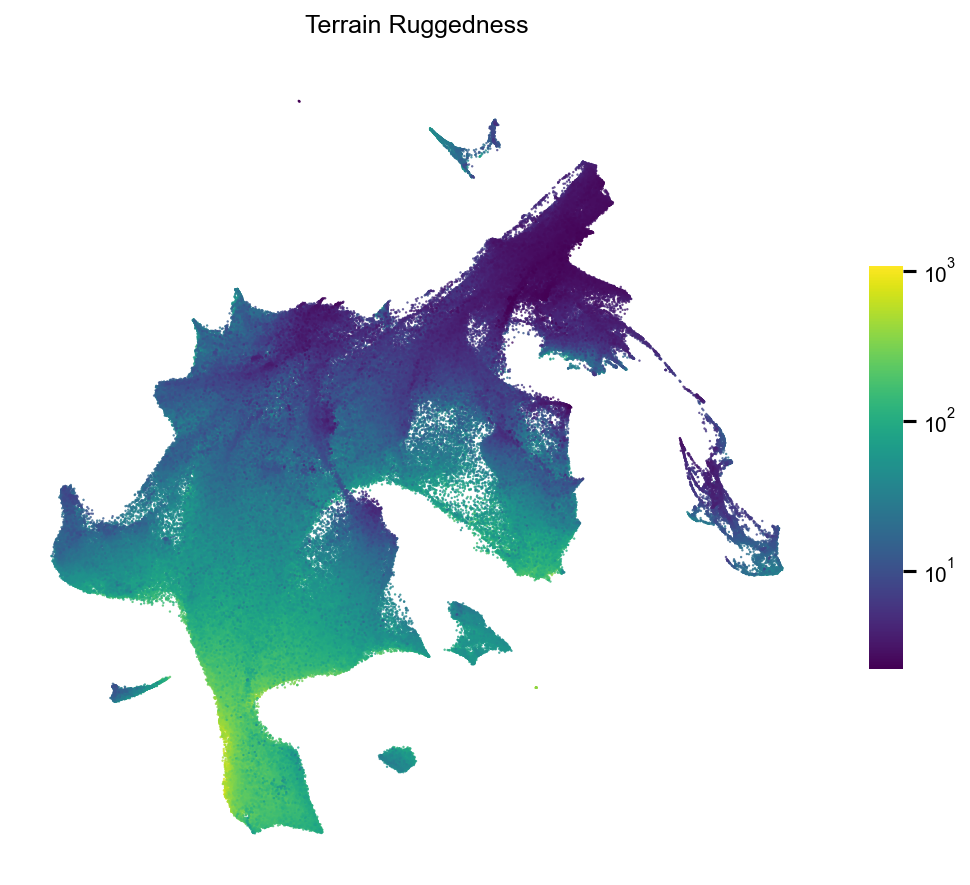

In [ ]:
# Visualize terrain ruggedness in the embedding space.
# Replicate Extended Data Figure 2b
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, LogNorm, ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as ticker

# Apply the custom, publication-ready plotting style defined previously.
set_plotting_style()

# Assume 'data_to_plot' dataframe is already loaded in the environment.
# Define the column containing the geographic feature to visualize.
vis_col = "std"

# Check for and rename embedding columns for consistency.
if "umap_0" in data_to_plot.columns:
    data_to_plot = data_to_plot.rename(columns={"umap_0": "umap_0", "umap_1": "umap_1"})
if "pac_0_cosine" in data_to_plot.columns:
    data_to_plot = data_to_plot.rename(columns={"pac_0_cosine": "pac_0", "pac_1_cosine": "pac_1"})
if "tsne_0_cosine" in data_to_plot.columns:
    data_to_plot = data_to_plot.rename(columns={"tsne_0_cosine": "tsne_0", "tsne_1_cosine": "tsne_1"})

# Create the figure and axes for the plot.
fig, ax = plt.subplots(figsize=(7, 6))

# Set the embedding method to display.
emb_to_show = "umap"

# Create a custom colormap based on 'viridis'.
custom_cmap = plt.cm.viridis

# Pre-process data for valid logarithmic mapping.
# LogNorm requires all values to be positive.
data_to_plot.loc[(data_to_plot[vis_col] <= 0), vis_col] = np.nan

# Get the min and max of the valid data range for normalization.
valid_data = data_to_plot.loc[~data_to_plot[vis_col].isna(), vis_col]
if len(valid_data) > 0:
    min_positive = valid_data.min()
    max_value = valid_data.max()
    
    # Sort points by value descending, so that low-value points are plotted on top.
    points_to_plot = data_to_plot[~data_to_plot[vis_col].isna()].copy()
    points_to_plot = points_to_plot.sort_values(by=vis_col, ascending=False)
    
    # Use LogNorm for logarithmic color scaling.
    norm = LogNorm(vmin=min_positive, vmax=max_value)
    
    scatter = ax.scatter(
        points_to_plot[f"{emb_to_show}_0"],
        points_to_plot[f"{emb_to_show}_1"],
        s=1.3,
        c=points_to_plot[vis_col],
        cmap=custom_cmap,
        norm=norm,
        alpha=0.8,
        rasterized=True, # Rasterize dense points to reduce vector file size.
        edgecolors='none'
    )
    
    # Add and configure a colorbar.
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=12)
    
    # Set explicit ticks for the logarithmic scale.
    cbar.set_ticks([10, 100, 1000])
    
    # Ensure the colorbar itself is not transparent.
    cbar.solids.set_alpha(1.0)
    cbar.ax.tick_params(axis='y', labelsize=10, color='black', direction='out', width=1.5, length=6)
    cbar.ax.yaxis.set_minor_locator(ticker.NullLocator()) # Hide minor ticks.
    cbar.outline.set_visible(False)

# Style the main plot axes for a clean appearance.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add a title to the plot.
plt.title('Terrain Ruggedness', fontsize=12, pad=15)

# Adjust layout to prevent labels from overlapping.
plt.tight_layout()

# Define  output paths.
output_dir = '/path/to/your/output/'
base_filename = f'{vis_col}_visualization'

# Save the figure in multiple formats.
plt.savefig(f'{output_dir}{base_filename}.pdf', 
            dpi=300, 
            bbox_inches='tight',
            format='pdf',
            transparent=True)

plt.savefig(f'{output_dir}{base_filename}.png', dpi=300, bbox_inches='tight')

# Display the final plot.
plt.show()

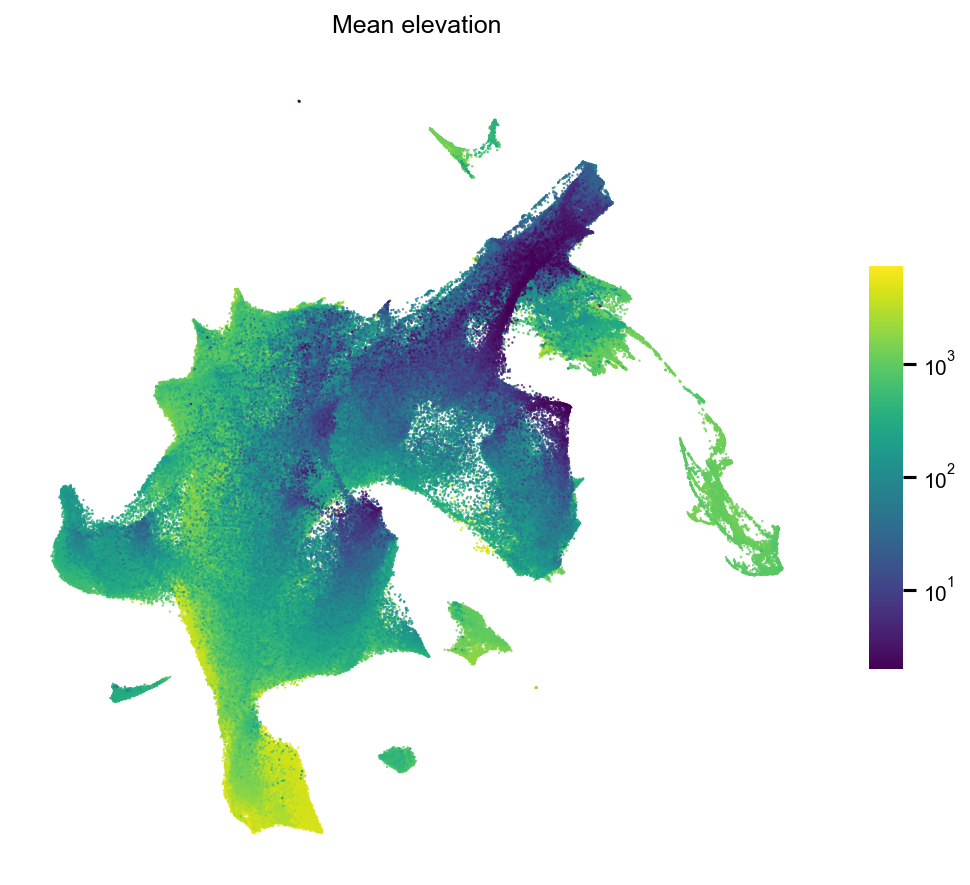

In [ ]:
# Visualize mean elevation in the embedding space using a logarithmic color scale.
# Replicate Extended Data Figure 2c
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, LogNorm, ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as ticker

# Define the column containing the geographic feature to visualize.
vis_col = "mean"

# Check for and rename embedding columns for consistency.
if "umap_0" in data_to_plot.columns:
    data_to_plot = data_to_plot.rename(columns={"umap_0": "umap_0", "umap_1": "umap_1"})
if "pac_0_cosine" in data_to_plot.columns:
    data_to_plot = data_to_plot.rename(columns={"pac_0_cosine": "pac_0", "pac_1_cosine": "pac_1"})
if "tsne_0_cosine" in data_to_plot.columns:
    data_to_plot = data_to_plot.rename(columns={"tsne_0_cosine": "tsne_0", "tsne_1_cosine": "tsne_1"})

# Create the figure and axes for the plot.
fig, ax = plt.subplots(figsize=(7, 6))

# Set the embedding method to display.
emb_to_show = "umap"

# Set the desired colormap.
custom_cmap = plt.cm.viridis

# Pre-process data for valid logarithmic mapping.
# LogNorm requires all values to be positive, so non-positive values are set to NaN.
data_to_plot.loc[(data_to_plot[vis_col] <= 0), vis_col] = np.nan

# Get the min and max of the valid data range for normalization.
valid_data = data_to_plot.loc[~data_to_plot[vis_col].isna(), vis_col]
if len(valid_data) > 0:
    min_positive = valid_data.min()
    max_value = valid_data.max()
    
    # Sort points by value descending, so that low-elevation points are plotted on top.
    points_to_plot = data_to_plot[~data_to_plot[vis_col].isna()].copy()
    points_to_plot = points_to_plot.sort_values(by=vis_col, ascending=False)
    
    # Use LogNorm for logarithmic color scaling.
    norm = LogNorm(vmin=min_positive, vmax=max_value)
    
    scatter = ax.scatter(
        points_to_plot[f"{emb_to_show}_0"],
        points_to_plot[f"{emb_to_show}_1"],
        s=1.3,
        c=points_to_plot[vis_col],
        cmap=custom_cmap,
        norm=norm,
        alpha=0.8,
        rasterized=True, # Rasterize dense points to reduce vector file size.
        edgecolors='none'
    )
    
    # Add and configure a colorbar.
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=12)
    
    # Set explicit ticks for the logarithmic scale (e.g., in meters).
    cbar.set_ticks([10, 100, 1000])
    
    # Ensure the colorbar itself is not transparent.
    cbar.solids.set_alpha(1.0)
    cbar.ax.tick_params(axis='y', labelsize=10, color='black', direction='out', width=1.5, length=6)
    cbar.ax.yaxis.set_minor_locator(ticker.NullLocator()) # Hide minor ticks.
    cbar.outline.set_visible(False)

# Style the main plot axes for a clean appearance.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add a title to the plot.
plt.title('Mean Elevation', fontsize=12, pad=15)

# Adjust layout to prevent labels from overlapping.
plt.tight_layout()

# Define output paths.
output_dir = '/path/to/your/output/'
base_filename = f'{vis_col}_visualization'

# Save the figure in multiple formats.
plt.savefig(f'{output_dir}{base_filename}.pdf', 
            dpi=300, 
            bbox_inches='tight',
            format='pdf',
            transparent=True)

plt.savefig(f'{output_dir}{base_filename}.png', dpi=300, bbox_inches='tight')

# Display the final plot.
plt.show()

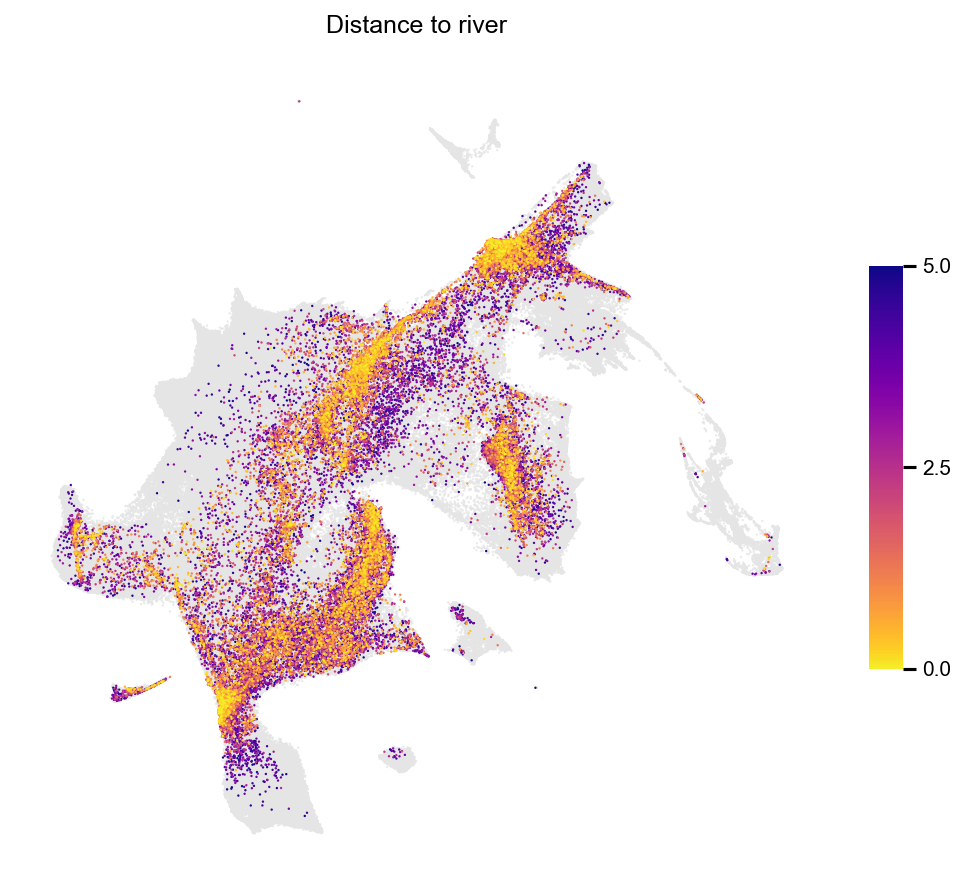

In [ ]:
# Visualize the distance to river, sea, and lake features in the embedding space
# Replicate Extended Data Figure 2d-f
# specify the feature to visualize using the `vis_col` variable.

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize, ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as ticker

# Assume 'data_to_plot' dataframe is already loaded in the environment.
# Define the column containing the geographic feature to visualize.
vis_col = "d_river"

# Check for and rename embedding columns for consistency.
if "umap_0" in data_to_plot.columns:
    data_to_plot = data_to_plot.rename(columns={"umap_0": "umap_0", "umap_1": "umap_1"})
if "pac_0_cosine" in data_to_plot.columns:
    data_to_plot = data_to_plot.rename(columns={"pac_0_cosine": "pac_0", "pac_1_cosine": "pac_1"})
if "tsne_0_cosine" in data_to_plot.columns:
    data_to_plot = data_to_plot.rename(columns={"tsne_0_cosine": "tsne_0", "tsne_1_cosine": "tsne_1"})

# Create the figure and axes for the plot.
fig, ax = plt.subplots(figsize=(7, 6))

# Set the embedding method to display.
emb_to_show = "umap"

# Define a distance threshold and create masks.
distance_threshold = 5000  # 5km in meters
mask_above_threshold = (data_to_plot[vis_col] > distance_threshold)
mask_within_threshold = (data_to_plot[vis_col] <= distance_threshold)

# Create a custom non-linear colormap to add more detail at lower values.
custom_cmap = plt.cm.plasma_r

# Plot points above the distance threshold (>5km, the diameter of our grid size) as a neutral gray background.
if sum(mask_above_threshold) > 0:
    ax.scatter(
        data_to_plot[f"{emb_to_show}_0"][mask_above_threshold],
        data_to_plot[f"{emb_to_show}_1"][mask_above_threshold],
        s=1.3,
        c='#E5E5E5',  # Light gray
        alpha=0.8,
        rasterized=True, # Rasterize dense points to reduce vector file size.
        edgecolors='none'
    )

# Plot points within the distance threshold (<=5km) using the custom colormap.
if sum(mask_within_threshold) > 0:
    points_to_plot = data_to_plot[mask_within_threshold].copy()
    # Sort points by distance descending, so that low-distance points are plotted on top.
    points_to_plot = points_to_plot.sort_values(by=vis_col, ascending=False)

    # Convert distance from meters to kilometers for plotting.
    distances_km = points_to_plot[vis_col] / 1000
    
    vmin = 0
    vmax = 5.0
    
    # Normalize the data to the 0-5km range for the colormap.
    norm = Normalize(vmin=vmin, vmax=vmax)

    scatter = ax.scatter(
        points_to_plot[f"{emb_to_show}_0"],
        points_to_plot[f"{emb_to_show}_1"],
        s=1.3,
        c=distances_km,
        cmap=custom_cmap,
        norm=norm,
        alpha=1,
        rasterized=True, # Rasterization is highly recommended for dense scatter plots.
        edgecolors='none'
    )
    # Add and configure a colorbar.
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=12)
    cbar.set_ticks([0, 2.5, 5.0])
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(axis='y', labelsize=10, direction='out', width=1.5, length=6, color='black')
   
# Style the main plot axes for a clean appearance.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add a title to the plot.
feature_name = vis_col.split('_')[-1].capitalize()
plt.title(f'Distance to {feature_name}', fontsize=12, pad=15)

# Adjust layout to prevent labels from overlapping.
plt.tight_layout()

# Define output paths.
output_dir = '/path/to/your/output/'
base_filename = f'distance_to_{feature_name}_visualization'

# Save the figure in multiple formats.
# The PDF version is configured for high-quality vector output.
plt.savefig(f'{output_dir}{base_filename}.pdf', 
            dpi=300, 
            bbox_inches='tight',
            format='pdf',
            transparent=True)

# The PNG version is a high-resolution raster format.
plt.savefig(f'{output_dir}{base_filename}.png', dpi=300, bbox_inches='tight')

# Display the final plot.
plt.show()

# Climate embedding analysis

## Load Embeddings

In [ ]:
# Load the saved embeddings and visualize 
import pandas as pd
import numpy as np
embeddings = np.load('/path/to/climate/embeddings.npy')
df = pd.read_parquet('/path/to/climate/embeddings_info.parquet')
df = df[["id"]]


In [ ]:
embeddings_2d = np.load('/home/zwy/Self-Supervised-Learning-for-Geography/zwy/SSL_results/embeddings/{folder}/embeddings_{n}_UMAP_cosine_20.npy'.format(folder=name,n=name))
#embeddings_tsne = np.load('/home/zwy/Self-Supervised-Learning-for-Geography/zwy/SSL_results/embeddings/{folder}/embeddings_{n}_tsne.npy'.format(folder=name,n=name))

## Dimension reduction using UMAP (Extended Data Figure 5)

In [ ]:

import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt

# Initialize UMAP transformer with cosine metric
umap_trans = umap.UMAP(
   n_neighbors=10, 
   n_components=2, 
   metric='cosine', 
   random_state=42
)

# Apply UMAP dimensionality reduction to embeddings
embeddings_2d = umap_trans.fit_transform(embeddings)

# Visualize dimensionality reduction results
plt.figure(figsize=(10, 8))
plt.scatter(
   embeddings_2d[:, 0], 
   embeddings_2d[:, 1], 
   s=1, 
   alpha=0.6,
   edgecolors='none'
)

plt.title('UMAP Visualization of Embeddings')

plt.show()

In [ ]:
# Load koben dataset
koben = pd.read_parquet("/path/to/koben.parquet")
df["umap_0"] = embeddings_2d[:,0]
df["umap_1"] = embeddings_2d[:,1]
koben = koben.merge(df, on='id', how='inner')

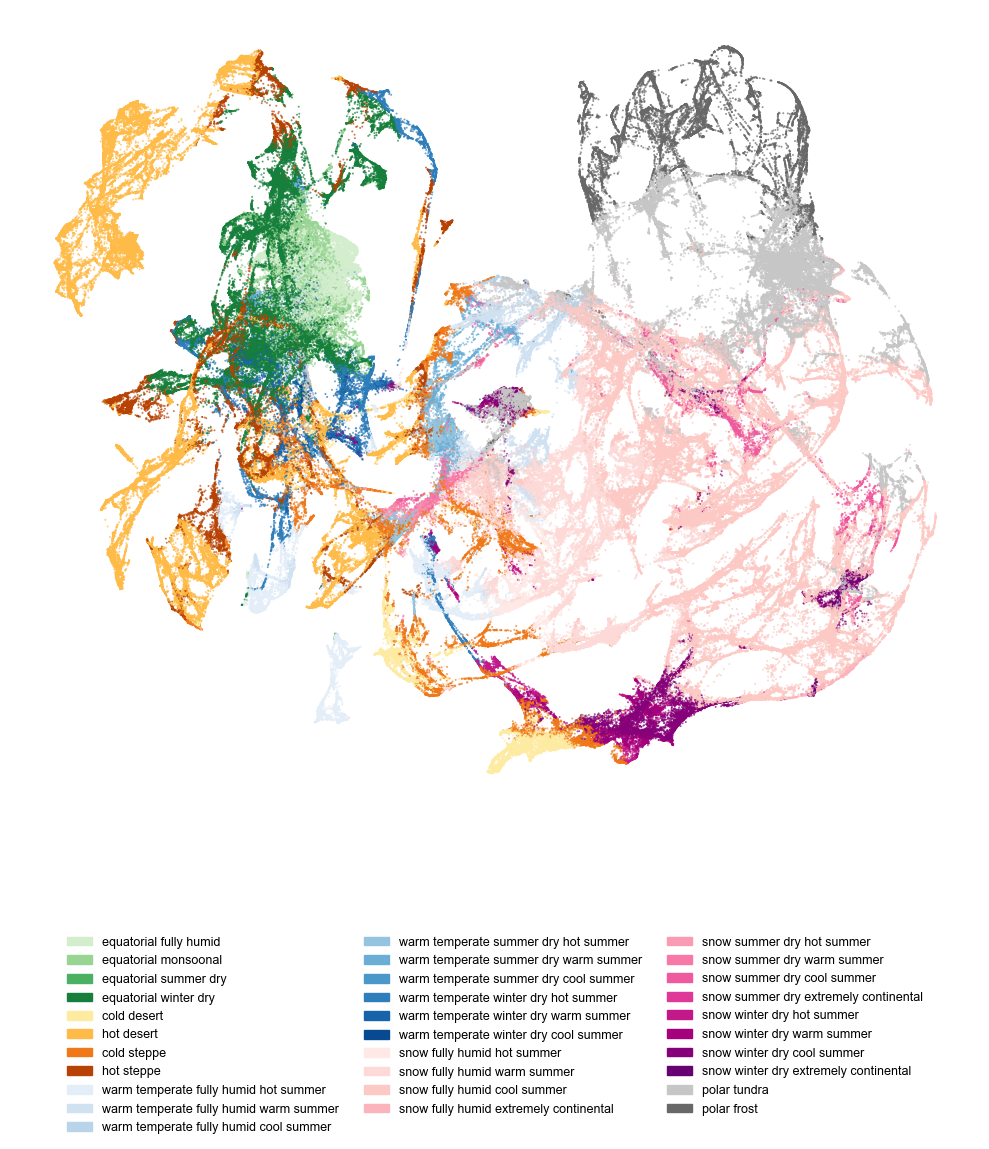

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib import rcParams

# Set Arial as the default font
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42  # This ensures text is editable in Illustrator
rcParams['ps.fonttype'] = 42   # This ensures text is editable in Illustrator


# Define the Köppen-Geiger climate classification (1-31) as per official definition
koppen_classes = {
    1: 'Af - equatorial fully humid',
    2: 'Am - equatorial monsoonal',
    3: 'As - equatorial summer dry',  # Note: This is missing in your data but will be included in legend
    4: 'Aw - equatorial winter dry',
    5: 'BWk - cold desert',
    6: 'BWh - hot desert',
    7: 'BSk - cold steppe',
    8: 'BSh - hot steppe',
    9: 'Cfa - warm temperate fully humid hot summer',
    10: 'Cfb - warm temperate fully humid warm summer',
    11: 'Cfc - warm temperate fully humid cool summer',
    12: 'Csa - warm temperate summer dry hot summer',
    13: 'Csb - warm temperate summer dry warm summer',
    14: 'Csc - warm temperate summer dry cool summer',
    15: 'Cwa - warm temperate winter dry hot summer',
    16: 'Cwb - warm temperate winter dry warm summer',
    17: 'Cwc - warm temperate winter dry cool summer',
    18: 'Dfa - snow fully humid hot summer',
    19: 'Dfb - snow fully humid warm summer',
    20: 'Dfc - snow fully humid cool summer',
    21: 'Dfd - snow fully humid extremely continental',
    22: 'Dsa - snow summer dry hot summer',
    23: 'Dsb - snow summer dry warm summer',
    24: 'Dsc - snow summer dry cool summer',
    25: 'Dsd - snow summer dry extremely continental',
    26: 'Dwa - snow winter dry hot summer',
    27: 'Dwb - snow winter dry warm summer',
    28: 'Dwc - snow winter dry cool summer',
    29: 'Dwd - snow winter dry extremely continental',
    30: 'ET - polar tundra',
    31: 'EF - polar frost'
}

koppen_short_codes = {
    1: 'Af',
    2: 'Am',
    3: 'As',  # Note: This is missing in data but will be included in legend
    4: 'Aw',
    5: 'BWk',
    6: 'BWh',
    7: 'BSk',
    8: 'BSh',
    9: 'Cfa',
    10: 'Cfb',
    11: 'Cfc',
    12: 'Csa',
    13: 'Csb',
    14: 'Csc',
    15: 'Cwa',
    16: 'Cwb',
    17: 'Cwc',
    18: 'Dfa',
    19: 'Dfb',
    20: 'Dfc',
    21: 'Dfd',
    22: 'Dsa',
    23: 'Dsb',
    24: 'Dsc',
    25: 'Dsd',
    26: 'Dwa',
    27: 'Dwb',
    28: 'Dwc',
    29: 'Dwd',
    30: 'ET',
    31: 'EF'
}


# Add the Köppen class names to the dataframe
koben['koppen_name'] = koben['koben'].map(koppen_short_codes)

# Create a custom colormap with 31 distinct colors
# Using a combination of colorblind-friendly palettes and grouping similar climate types
colors = []

# A climates (1-4) - Greens
colors.extend(sns.color_palette("Greens", 4))

# B climates (5-8) - Oranges and yellows
colors.extend(sns.color_palette("YlOrBr", 4))

# C climates (9-17) - Blues
colors.extend(sns.color_palette("Blues", 9))

# D climates (18-29) - Purples and reds
colors.extend(sns.color_palette("RdPu", 12))

# E climates (30-31) - Greys
colors.extend(sns.color_palette("Greys", 2))

# Ensure we have exactly 31 colors
koppen_cmap = ListedColormap(colors[:31])

# Create the figure
plt.figure(figsize=(10, 10))

# Plot the scatter points
scatter = plt.scatter(
    koben['umap_0'], 
    koben['umap_1'], 
    c=koben['koben'],
    cmap=koppen_cmap,
    s=2,
    alpha=0.7,
    edgecolors='none'
)

# Customize the plot
#plt.title('UMAP Visualization by Köppen-Geiger Climate Classification', fontsize=18)
#plt.xlabel('UMAP Dimension 1', fontsize=14)
#plt.ylabel('UMAP Dimension 2', fontsize=14)

# Create patches for the legend
legend_patches = []

# Group all climate types in a single structured legend
for i in range(1, 32):  # 1 to 31 inclusive
    # Check if climate type is in the dataset (except for type 3 which we always want to include)
    if i == 3 or i in koben['koben'].values:
        color = colors[i-1]  # -1 because colors are 0-indexed
        patch = mpatches.Patch(color=color, label=koppen_classes[i].split(' - ')[1])
        legend_patches.append(patch)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

# Add a single legend with multiple columns at the bottom
plt.figlegend(
    handles=legend_patches,
    loc='upper center', 
    bbox_to_anchor=(0.5, 0.05),  # Position at bottom center
    ncol=3,  # 5 columns for clean organization
    fontsize=9,
    markerscale=4,  # Larger legend markers
    frameon=False  # No frame around the legend
)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.15, 1, 0.98])  # Leave space at the bottom for the legend

# Save as PDF with editable text
plt.savefig('/home/zwy/Self-Supervised-Learning-for-Geography/plotting/results_materials/Extended_data_Fig4/koppen_umap_visualization.pdf', 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight')

# Also save as PNG for quick reference
plt.savefig('/home/zwy/Self-Supervised-Learning-for-Geography/plotting/results_materials/Extended_data_Fig4/koppen_umap_visualization.png', 
            dpi=300, 
            bbox_inches='tight')

plt.show()

In [ ]:


# Set Arial as the default font
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42  # This ensures text is editable in Illustrator
rcParams['ps.fonttype'] = 42   # This ensures text is editable in Illustrator

# Define the mapping from detailed Köppen-Geiger classes to major climate groups
koppen_major_groups = {
    1: 'A', # Af - equatorial fully humid
    2: 'A', # Am - equatorial monsoonal
    3: 'A', # As - equatorial summer dry
    4: 'A', # Aw - equatorial winter dry
    5: 'B', # BWk - cold desert
    6: 'B', # BWh - hot desert
    7: 'B', # BSk - cold steppe
    8: 'B', # BSh - hot steppe
    9: 'C', # Cfa - warm temperate fully humid hot summer
    10: 'C', # Cfb - warm temperate fully humid warm summer
    11: 'C', # Cfc - warm temperate fully humid cool summer
    12: 'C', # Csa - warm temperate summer dry hot summer
    13: 'C', # Csb - warm temperate summer dry warm summer
    14: 'C', # Csc - warm temperate summer dry cool summer
    15: 'C', # Cwa - warm temperate winter dry hot summer
    16: 'C', # Cwb - warm temperate winter dry warm summer
    17: 'C', # Cwc - warm temperate winter dry cool summer
    18: 'D', # Dfa - snow fully humid hot summer
    19: 'D', # Dfb - snow fully humid warm summer
    20: 'D', # Dfc - snow fully humid cool summer
    21: 'D', # Dfd - snow fully humid extremely continental
    22: 'D', # Dsa - snow summer dry hot summer
    23: 'D', # Dsb - snow summer dry warm summer
    24: 'D', # Dsc - snow summer dry cool summer
    25: 'D', # Dsd - snow summer dry extremely continental
    26: 'D', # Dwa - snow winter dry hot summer
    27: 'D', # Dwb - snow winter dry warm summer
    28: 'D', # Dwc - snow winter dry cool summer
    29: 'D', # Dwd - snow winter dry extremely continental
    30: 'E', # ET - polar tundra
    31: 'E'  # EF - polar frost
}

# Define human-readable names for the major climate groups
major_group_names = {
    'A': 'Tropical (A)',
    'B': 'Arid (B)',
    'C': 'Temperate (C)',
    'D': 'Continental (D)',
    'E': 'Polar (E)'
}

# More descriptive names for the second-level classification
second_level_groups = {
    # Group by the second letter in the Köppen code
    'f': 'Fully humid (f)',
    'm': 'Monsoonal (m)',
    's': 'Summer dry (s)',
    'w': 'Winter dry (w)',
    'W': 'Desert (W)',
    'S': 'Steppe (S)',
    'T': 'Tundra (T)',
    'F': 'Frost (F)'
}

# Create a mapping from detailed Köppen class to second-level group
koppen_second_level = {
    1: 'f',  # Af
    2: 'm',  # Am
    3: 's',  # As
    4: 'w',  # Aw
    5: 'W',  # BWk
    6: 'W',  # BWh
    7: 'S',  # BSk
    8: 'S',  # BSh
    9: 'f',  # Cfa
    10: 'f', # Cfb
    11: 'f', # Cfc
    12: 's', # Csa
    13: 's', # Csb
    14: 's', # Csc
    15: 'w', # Cwa
    16: 'w', # Cwb
    17: 'w', # Cwc
    18: 'f', # Dfa
    19: 'f', # Dfb
    20: 'f', # Dfc
    21: 'f', # Dfd
    22: 's', # Dsa
    23: 's', # Dsb
    24: 's', # Dsc
    25: 's', # Dsd
    26: 'w', # Dwa
    27: 'w', # Dwb
    28: 'w', # Dwc
    29: 'w', # Dwd
    30: 'T', # ET
    31: 'F'  # EF
}

# Add the Köppen class major group to the dataframe
koben['koppen_major'] = koben['koben'].map(koppen_major_groups)
koben['koppen_second'] = koben['koben'].map(koppen_second_level)

# Option 1: Color by major groups (A, B, C, D, E)
# Create a distinct color for each major group
major_colors = {
    'A': '#1a9850',  # Green for Tropical
    'B': '#fdae61',  # Orange for Arid
    'C': '#2c7fb8',  # Blue for Temperate
    'D': '#d7191c',  # Red for Continental
    'E': '#7570b3'   # Purple for Polar
}

# Create a mapping of each unique major group to a numeric index for coloring
unique_major_groups = sorted(koben['koppen_major'].unique())
major_group_indices = {group: i for i, group in enumerate(unique_major_groups)}

# Map each data point to its major group index
koben['major_group_index'] = koben['koppen_major'].map(major_group_indices)

# Create color list from the major_colors dictionary
major_cmap_colors = [major_colors[group] for group in unique_major_groups]
major_cmap = ListedColormap(major_cmap_colors)

# Option 2: Color by second-level groups
# Create colors for second-level groups
second_level_colors = {
    'f': '#41ab5d',  # Dark green for fully humid
    'm': '#74c476',  # Medium green for monsoonal
    's': '#addd8e',  # Light green for summer dry
    'w': '#d9f0a3',  # Pale green for winter dry
    'W': '#fd8d3c',  # Dark orange for desert
    'S': '#fdbe85',  # Light orange for steppe
    'T': '#807dba',  # Dark purple for tundra
    'F': '#bcbddc'   # Light purple for frost
}

# Create a mapping of each unique second-level group to a numeric index
unique_second_groups = sorted(koben['koppen_second'].unique())
second_group_indices = {group: i for i, group in enumerate(unique_second_groups)}

# Map each data point to its second-level group index
koben['second_group_index'] = koben['koppen_second'].map(second_group_indices)

# Create color list from the second_level_colors dictionary
second_cmap_colors = [second_level_colors[group] for group in unique_second_groups]
second_cmap = ListedColormap(second_cmap_colors)

# Choose which grouping to use (set to 'major' or 'second')
grouping_choice = 'second_group_index'

if grouping_choice == 'major':
    color_column = 'major_group_index'
    cmap = major_cmap
    group_colors = major_colors
    group_names = major_group_names
    group_column = 'koppen_major'
else:  # second level
    color_column = 'second_group_index'
    cmap = second_cmap
    group_colors = second_level_colors
    group_names = second_level_groups
    group_column = 'koppen_second'

# Create the figure
plt.figure(figsize=(10, 10))

# Plot the scatter points
scatter = plt.scatter(
    koben['umap_0'], 
    koben['umap_1'], 
    c=koben[color_column],
    cmap=cmap,
    s=2,
    alpha=0.7,
    edgecolors='none'
)

# Hide axis elements
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

# Create patches for the legend
legend_patches = []

# Add each group to the legend
for group in sorted(koben[group_column].unique()):
    color = group_colors[group]
    patch = mpatches.Patch(color=color, label=group_names[group])
    legend_patches.append(patch)

# Add a single legend with multiple columns at the bottom
plt.figlegend(
    handles=legend_patches,
    loc='upper center', 
    bbox_to_anchor=(0.5, 0.05),  # Position at bottom center
    ncol=3,  # 3 columns for clean organization
    fontsize=10,
    markerscale=4,  # Larger legend markers
    frameon=False  # No frame around the legend
)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.15, 1, 0.98])  # Leave space at the bottom for the legend

# Save as PDF with editable text
plt.savefig('/home/zwy/Self-Supervised-Learning-for-Geography/plotting/results_materials/Extended_data_Fig4/koppen_major_groups2.pdf', 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight')

# Also save as PNG for quick reference
plt.savefig('/home/zwy/Self-Supervised-Learning-for-Geography/plotting/results_materials/Extended_data_Fig4/koppen_major_groups2.png', 
            dpi=300, 
            bbox_inches='tight')

plt.show()